# Installing libraries and dataset, preprocessing

In [ ]:
!pip3 install -U statsmodels
!pip3 install pmdarima

     |████████████████████████████████| 9.8 MB 8.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 1.4 MB 7.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
%matplotlib inline
import warnings                   
warnings.filterwarnings("ignore")
import pmdarima as pm

In [ ]:
df = pd.read_csv("/content/sample_data/daily-website-visitors.csv")

df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
df['Page.Loads'] = df['Page.Loads'].str.replace(',', '')
df['Count'] = df['Page.Loads'].astype(str).astype(int)
df = df[['Date', 'Count']]
df.set_index('Date', inplace=True)

# take data upto 12/31/2019 due to covid outbreak in 2020, whose effect on this data is out of scope for us.
df = df[df.index <= '12/31/2019']


PLOT FOR 1 YEAR. THE DATA IS PERIODIC (IDENTICAL GRAPH FOR EACH 365 DAYS) LOWEST AROUND JANUARY AND PEAK DURING MAY)

In [ ]:
plt.figure(figsize=(15,10)) 
plt.plot(df[:365]['Count'], label='Client Requests')
plt.title('Website http requests over time') 
plt.xlabel("Time") 
plt.ylabel("Hit count")
plt.legend(loc='best')
plt.show()

## SETTING ARIMA PARAMETERS BY CHECKING PACF, STATIONARITY AND ACF. NEXT COMPARE IT TO AUTO ARIMA (WITHOUT SEASONALITY AND WITH SEASONALITY).

### FIRST, LET'S FIND THE STATIONARITY (d), PACF(for p) and ACF(for q) for ARIMA model with params (p,d,q). 

#### TODO: TAKE log returns for more stationarity

## NOTE: PACF and ACF with diff(log(Count)) making much more sense -> clearly weekly correlation exists! 


ADF TEST FOR STATIONARITY

In [ ]:
# ADF TEST FOR STATIONARITY
# Null Hypothesis (H0): The time series is non-stationary. It has some time dependent structure.
# Alternate Hypothesis (H1): The time series is stationary. It does not have time-dependent structure.
# The more negative ADF statistic is, the more likely we are to reject the null hypothesis.

# p-value > 0.05: TIME SERIES NON-STATIONARY. Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: TIME SERIES STATIONARY. Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

# TAKE THIS. SET (p,d,q) = (p,0,q) AS THERE IS NO NEED OF I IN ARIMA HERE, NO UPWARD/DOWNWARD TREND, ALREADY STATIONARY. NEXT CELL IS JUST LIKE THAT.

from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Count'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.071149
p-value: 0.001081
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [ ]:
# running adf test on log return np.log()

# result = adfuller(np.log(df['Count']).diff().dropna())
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

PACF FOR PARAMETER p (for AR)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

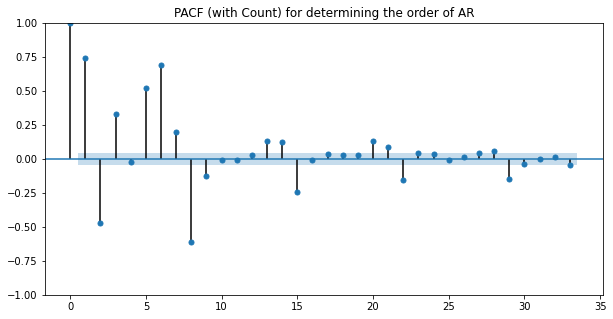

In [ ]:
# Identification of an AR model is often best done with the PACF.
# We know for an AR model, the PACF tapers towards 0 past the order of the model. 
# By order of the model we mean the most extreme lag of x (date parameter).
# Based on PACF, we are likely dealing with a auto-regressive (AR) process.
# For simplicity, let's stick to the order 8.
# We can ignore the lags within/near the blue bars as they are not statistically significant.

fig, ax = plt.subplots(figsize=(10,5))
pl = plot_pacf(df['Count'], ax=ax, title='PACF (with Count) for determining the order of AR')

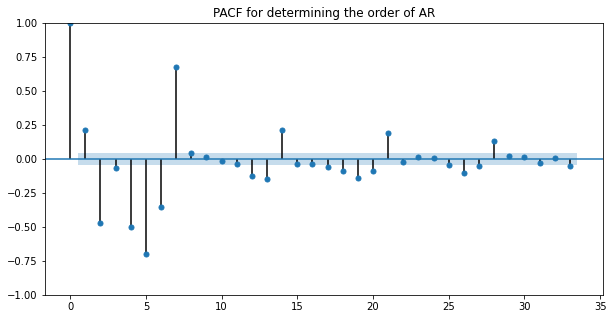

In [ ]:
# Now, finding PACF (with diff(log(Count))) for determining the order of AR
# NOTE: PACF and ACF with diff(log(Count)) making much more sense -> clearly weekly correlation exists! 
df2 = df.copy()
df2['log_count'] = np.log(df2['Count']).diff()
fig, ax = plt.subplots(figsize=(10,5))
pl = plot_pacf(df2['log_count'].dropna(), ax=ax, title='PACF for determining the order of AR')

Plotting ACF for parameter q (for MA)

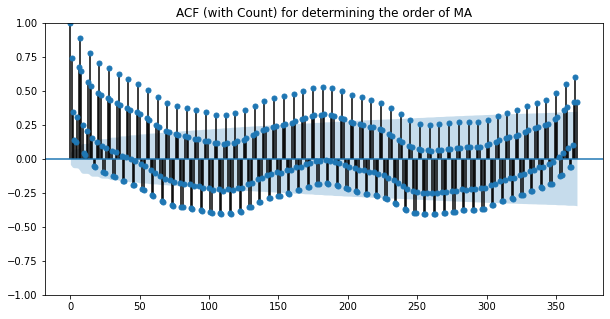

In [ ]:
# x represents the number of days. almost represents a sine curve (and notice most lag days are lying outside the blue bars)
fig, ax = plt.subplots(figsize=(10,5))
pl = plot_acf(df['Count'], ax=ax, title='ACF (with Count) for determining the order of MA', lags=365)

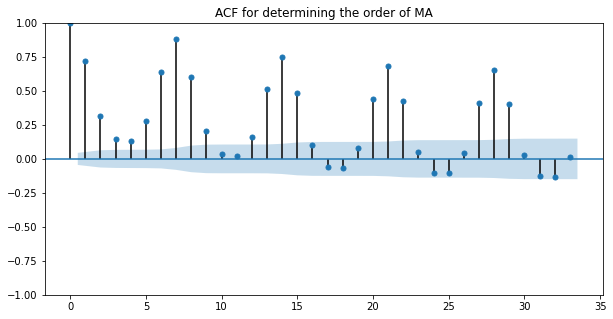

In [ ]:
# For keeping the model simpler, let's try to find an order which is far lower than this range.
# To do that, we need ACF of diff(log(Count))
# Besides yearly trend above, we can see a clear weekly pattern below, as the correlation in multiples of lag 7 is quite significant. So, let's take the order 7 for our MA model (q=7)
df2 = df.copy()
df2['log_count'] = np.log(df2['Count'])
fig, ax = plt.subplots(figsize=(10,5))
pl = plot_acf(df2['log_count'].dropna(), ax=ax, title='ACF for determining the order of MA')

## Building the ARIMA model with the (p,d,q) parameters we've chosen. 

In [ ]:
Ntest = int(0.1 * len(df)) # doing 90-10 train-test split, test about 7 months
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]
len(train), len(test)

(1742, 193)

In [ ]:
train_idx = df.index <= train.index[-1] # ndarray of size len(df), stores True if df date (index) is <= Timestamp('2020-01-16 00:00:00') for 90-10 split
test_idx = df.index > train.index[-1] # ndarray of size len(df) for test cases. 

# Functions from udemy tutorial

In [ ]:
# df.loc[train_idx, 'ARIMA(8,0,7)'] = arima_result.predict(start=train.index[0], end=train.index[-1])

In [ ]:
# df[['Count', 'ARIMA(8,0,7)']].plot(figsize=(15,10))
# prediction_result = arima_result.get_forecast(Ntest)
# forecast = prediction_result.predicted_mean
# df.loc[test_idx, 'ARIMA(8,0,7)'] = forecast
# prediction_result.conf_int()

In [ ]:
def rmse(result, is_logged):
  forecast = result.forecast(Ntest)
  if is_logged:
    forecast = np.exp(forecast)
  
  t = test['Count']
  y = forecast
  return np.sqrt(np.mean((t-y)**2))

In [ ]:
def plot_fit_and_forecast_int(result, d, col='Count'):
  fig, ax = plt.subplots(figsize=(15,5))

  # plot the actual data (train + test)
  ax.plot(df[col], color='blue', label='actual data (train + test)')

  # plot the curve fitted on train set
  train_pred = result.predict(start=train.index[d], end=train.index[-1])
  ax.plot(train.index[d:], train_pred, color='red', label='fitted on train data')

  # forecast the test set
  prediction_result = result.get_forecast(Ntest)
  conf_int = prediction_result.conf_int()
  lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
  forecast = prediction_result.predicted_mean
  ax.plot(test.index, forecast, color='black', label='forecast on test data')
  ax.set_title('Plotting actual vs predicted data')
  ax.fill_between(test.index, lower, upper, color='red', alpha=0.3)
  ax.legend()

  return forecast


In [ ]:
def plot_forecast_result(forecast, col='Count'):
  fig, ax = plt.subplots(figsize=(15,5))
  # plot the actual test data
  ax.plot(test.index, df['Count'].iloc[-Ntest:], color='blue', label='actual')
  # plot the predicted data for test
  ax.plot(test.index, forecast, color='red', label='predicted')
  ax.legend()

# ARIMA (daily)
# (p,d,q)   RMSE values
---
* (🙂) (7,0,7) => mse= 1061830.1675933495 		rmse= 1030.4514387361248 	nrmse= 0.1475868574528967  mae 813.7787150079824

 

* (7,1,7) => mse= 1141067.806233072 		rmse= 1068.2077542468376 	nrmse= 0.15299452223529614

---
* (8,0,7) => mse= 1106383.6284172977 		rmse= 1051.8477211161783 	nrmse= 0.15065134934348012


* (8,1,7) => mse= 1072980.6737855156 		rmse= 1035.8478043542475 	nrmse= 0.14835975427588763

---
increasing d to more than 1 yields higher (bad) RMSE values


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(train['Count'], order=(7,0,7))
arima_result = arima.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
# print(rmse(arima_result, False))
# plot_fit_and_forecast_int(arima_result)

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_scores(result):
  mse = mean_squared_error(test['Count'],result.forecast(Ntest))
  rmse = math.sqrt(mse)
  nrmse = rmse / (max(df['Count']) - min(df['Count']))
  mae = mean_absolute_error(test['Count'],result.forecast(Ntest))
  print("mse=",mse,"\t\trmse=",rmse,"\tnrmse=",nrmse,"\tmae",mae)

In [ ]:
get_scores(arima_result)

mse= 1061830.1675933495 		rmse= 1030.4514387361248 	nrmse= 0.1475868574528967 	mae 813.7787150079824


# SARIMAX (daily)
# (p,d,q) (P,D,Q,s)
---
* 🙂 order=(0,1,0), seasonal_order=(1,0,1,168)) 
  * mse= 1373751.2065052283 		rmse= 1172.0713316625522 	nrmse= 0.1678704284821759

---
* order=(0,1,0), seasonal_order=(1,0,1,7))
  * mse= 4868304.157399478 		rmse= 2206.423385798718 	nrmse= 0.31601595327967885
---


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax = SARIMAX(train['Count'], order=(0,1,0), seasonal_order=(1,0,1,168)) 
sarimax_result = sarimax.fit()
# arima_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
get_scores(sarimax_result)

mse= 1466287.9096954472 		rmse= 1210.9037574041329 	nrmse= 0.1734322196224768 	mae 992.5462766828618


# PMD AUTO ARIMA

In [ ]:
import math
from sklearn.metrics import mean_squared_error

def get_auto_scores(forecast):
  mse = mean_squared_error(test['Count'],forecast)
  rmse = math.sqrt(mse)
  nrmse = rmse / (max(df['Count']) - min(df['Count']))
  print("mse=",mse,"\t\trmse=",rmse,"\tnrmse=",nrmse)

In [ ]:
# auto_model = pm.auto_arima(train, seasonal=True, m=7)
auto_model = pm.auto_arima(train['Count'], trace=True, suppress_warnings=True, max_p=12, max_q)



In [ ]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1742
Model:             SARIMAX(0, 1, 0)x(1, 0, [1, 2], 7)   Log Likelihood              -12625.448
Date:                                Thu, 05 May 2022   AIC                          25258.897
Time:                                        17:30:22   BIC                          25280.746
Sample:                                             0   HQIC                         25266.976
                                               - 1742                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9991      0.001   1640.956      0.000       0.998       1.000
ma.S.L7       -0.6850      0.019    -36.817      0.000      -0.721      -0.649
ma.S.L14      -0.2053      0.020    -10.375      0.000      -0.244      -0.167
sigma2       1.15e+05   2852.456     40.314      0.000    1.09e+05    1.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.99   Jarque-Bera (JB):               346.24
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
auto_forecast = auto_model.predict(n_periods=Ntest)
get_auto_scores(auto_forecast)

mse= 3258490.333553978 		rmse= 1805.128896659177 	nrmse= 0.2585403747721537


# LET'S TRY WITH LOGe(COUNT) AS IT WAS GIVING MORE PROMISING RESULTS

# ARIMA (daily) using log
# (p,d,q)   RMSE values
---
* mse= 1126283.1277794214 		rmse= 1061.26487164111 	nrmse= 0.15200012484117872

* 🙂 (7,1,7) mse= 1096321.2441222689 		rmse= 1047.0536013606318 	nrmse= 0.1499647094472403
---
* (8,0,7) mse= 1160921.5505333545 		rmse= 1077.4606955863192 	nrmse= 0.1543197788006759


* (8,1,7) mse= 1110888.3846147067 		rmse= 1053.9868996409332 	nrmse= 0.15095773412216174



In [ ]:
df = df[['Count']]
df['LogCount'] = np.log(df['Count'])
Ntest = int(0.1 * len(df)) # doing 90-10 train-test split, test about 7 months
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]
len(df), len(train), len(test)

(1935, 1742, 193)

In [ ]:
import math
from sklearn.metrics import mean_squared_error

def get_scores_log(result):
  forecast = result.forecast(Ntest)
  forecast = np.exp(forecast)
  mse = mean_squared_error(test['Count'],forecast)
  rmse = math.sqrt(mse)
  nrmse = rmse / (max(df['Count']) - min(df['Count']))
  print("mse=",mse,"\t\trmse=",rmse,"\tnrmse=",nrmse)

In [ ]:
arima = ARIMA(train['LogCount'], order=(7,0,7))
arima_result_log = arima.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
# plot_fit_and_forecast_int(arima_result_log, 1, col='LogCount')
# print(rmse(arima_result_log, True)) 

In [ ]:
get_scores_log(arima_result_log)

mse= 1126283.1277794214 		rmse= 1061.26487164111 	nrmse= 0.15200012484117872


# CONDENSE THE DATA INTO MEAN OF EACH WEEK AND COMPUTE (as we need seasonality of yearly data but seasonality=365 is too computationally heavy)

In [ ]:
import pandas as pd
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
%matplotlib inline
import warnings                   
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/content/sample_data/daily-website-visitors.csv")

df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
df['Page.Loads'] = df['Page.Loads'].str.replace(',', '')
df['Count'] = df['Page.Loads'].astype(str).astype(int)
df = df[['Date', 'Day', 'Count']]
df.set_index('Date', inplace=True)

In [ ]:
# take data upto 12/31/2019
df = df[df.index <= '12/31/2019']

# drop first three data as we want len(df) % 7 = 0 for weekly data
df.drop(df.head(3).index, inplace = True)

# we now have 276 weeks: to make it pretty, let's take a whole 270 weeks and make 90-10 split.
df.drop(df.head(6*7).index, inplace = True)

# our data starts from Wednesday, so on a weekly basis date, let's take the median date of Saturdays for our index
df_saturdays = df[df['Day'] == 'Saturday']

# we will take the mean of each week to get 270 rows of weekly data
df = df.groupby(np.arange(len(df)) // 7).mean().astype(int)

# finally change the index as the corresponding Saturday dates
df.index = df_saturdays.index

In [ ]:
Ntest = int(0.1 * len(df)) # doing 90-10 train-test split, test about 7 months
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]
len(df), len(train), len(test)

(270, 243, 27)

In [ ]:
train_idx = df.index <= train.index[-1] # ndarray of size len(df), stores True if df date (index) is <= Timestamp('2020-01-16 00:00:00') for 90-10 split
test_idx = df.index > train.index[-1] # ndarray of size len(df) for test cases. 

In [ ]:
def get_first_day_of_year():
  first_day_of_year = []
  for i in range(1, len(df)):
    prev_ind_yr = df.index[i-1].year
    curr_ind_yr = df.index[i].year
    if prev_ind_yr + 1 == curr_ind_yr:
      first_day_of_year.append(df.index[i])
  return first_day_of_year

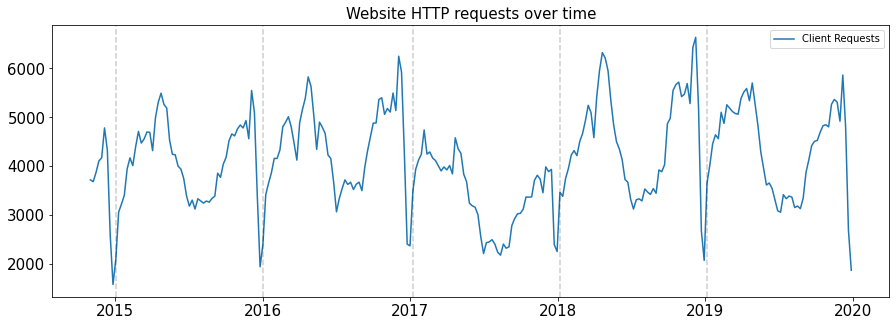

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df['Count'], label='Client Requests')
plt.title('Website HTTP requests over time', fontdict={'fontsize':15}) 
plt.tick_params(axis='both', labelsize=15)
# plt.xticks(np.arange(min(df.index),max(df.index),10))
# for plotting the year-separators, get the starting of each year date
first_day_of_year = get_first_day_of_year()
for day in first_day_of_year:
  plt.axvline(day, color='k', linestyle='--', alpha=0.2)
plt.legend(loc='best')
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# arima = ARIMA(train['Count'], order=(52,0,52))
arima = SARIMAX(train['Count'], order=(0,1,0), seasonal_order=(1,0,1,52)) 

# ARIMA: (52,1,52) => 684.1795738254816
# SARIMAX: (0,1,0)(1,0,1,52) => 375.12137423520073
arima_result = arima.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Count   No. Observations:                  243
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 52)   Log Likelihood               -1757.996
Date:                              Thu, 05 May 2022   AIC                           3521.992
Time:                                      15:16:57   BIC                           3532.459
Sample:                                  11-01-2014   HQIC                          3526.209
                                       - 06-22-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52       0.9632      0.019     50.782      0.000       0.926       1.000
ma.S.L52      -0.6366      0.095     -6.734      0.000      -0.822      -0.451
sigma2      9.076e+04   5413.414     16.766      0.000    8.02e+04    1.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                99.30
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.11
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast = plot_fit_and_forecast_int(arima_result, 0, 'Count')

In [ ]:
plot_forecast_result(forecast, 'Count')

In [ ]:
print(rmse(arima_result, False))

375.12137423520073


In [ ]:
rmse(arima_result, False)/(max(df['Count']) - min(df['Count']))
# this is probably max(test['df']) - min(test['df']) 

0.0742814602445942

In [ ]:
df

,Count
Date,
2014-11-01,3722
2014-11-08,3686
2014-11-15,3873
2014-11-22,4106
2014-11-29,4175
...,...
2019-11-30,4921
2019-12-07,5864
2019-12-14,4801
